# Install and import needed libraries

In [ ]:
!pip install torchtext==0.6.0 --quiet
!python -m spacy download fr_core_news_sm --quiet

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 1.2MB 8.0MB/s 
     |████████████████████████████████| 14.7MB 5.6MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, BucketIterator, TabularDataset
import numpy as np
import pandas as pd
import spacy, random
from torch.utils.tensorboard import SummaryWriter
from torchtext.data.metrics import bleu_score
spacy_french = spacy.load("fr_core_news_sm")
spacy_english = spacy.load("en_core_web_sm")

In [ ]:
def tokenize_french(text):
  return [token.text for token in spacy_french.tokenizer(text)]

def tokenize_english(text):
  return [token.text for token in spacy_english.tokenizer(text)]

french = Field(tokenize=tokenize_french, lower=True,
               init_token="<sos>", eos_token="<eos>")

english = Field(tokenize=tokenize_english, lower=True,
               init_token="<sos>", eos_token="<eos>")

In [ ]:
fields = {
  'English': ('English', english ),
  'French': ('French', french)
}

train_data, valid_data, test_data = TabularDataset.splits(
    path='/content/drive/MyDrive/Colab Notebooks/Machine_Translation/',
    train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv',
    fields=fields

)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
french.build_vocab(train_data, max_size=10000, min_freq=3)
english.build_vocab(train_data, max_size=10000, min_freq=3)

In [ ]:
# count = 0
# for data in train_iterator:
#   if count < 1 :
#     print("Shapes", data.English.shape, data.French.shape)
#     print()
#     print("English - ",*data.English, " Length - ", len(data.English))
#     print()
#     print("French - ",*data.French, " Length - ", len(data.French))
#     temp_ger = data.English
#     temp_eng = data.French
#     count += 1

In [ ]:
# temp_eng_idx = (temp_eng).cpu().detach().numpy()
# temp_ger_idx = (temp_ger).cpu().detach().numpy()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)

    def forward(self, x):
        embedding = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedding)

        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self,input_size, embedding_size, hidden_size, output_size, num_layers, p):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))

        outputs, (hidden, cell) = self.rnn(embedding, (hidden,cell))

        predictions = self.fc(outputs)

        predictions = predictions.squeeze(0)

        return predictions, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ration=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(french.vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        hidden, cell = self.encoder(source)

        x = target[0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)

            outputs[t] = output

            best_guess = output.argmax(1)

            x = target[t] if random.random() < teacher_force_ration else best_guess
        return outputs

# Comment out


In [ ]:
def translate_sentence(model, sentence, english, french, device, max_length=60):
    spacy_english = spacy.load("en_core_web_sm")

    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_english(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, english.init_token)
    tokens.append(english.eos_token)
    text_to_indices = [english.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        hidden, cell = model.encoder(sentence_tensor)

    outputs = [french.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [french.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]

def bleu(data, model, english, french, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["English"]
        trg = vars(example)["French"]

        prediction = translate_sentence(model, src, english, french, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)
    return bleu_score(outputs, targets)
    
    # weights=(1.0/5.0, 1.0/5.0, 1.0/5.0, 1.0/5.0, 1.0/5.0,)
    # return corpus_bleu(outputs, targets,weights)
# def checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss):
#     print('saving')
#     print()
#     state = {'model': model,'best_loss': best_loss,'epoch': epoch,'rng_state': torch.get_rng_state(), 'optimizer': optimizer.state_dict(),}
#     torch.save(state, '/content/checkpoint-NMT')
#     torch.save(model.state_dict(),'/content/checkpoint-NMT-SD')


# Config parameters

In [ ]:
NUM_EPOCHS = 50
learning_rate = 0.001
batch_size = 64
PATIENCE = 5
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder = len(english.vocab)
input_size_decoder = len(french.vocab)
output_size = len(french.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

#TensorBoard
# writer = SummaryWriter(f"runs/loss_plot")
# step = 0

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch = True,
    sort_key= lambda x: len(x.English),
    device = device

)

In [ ]:
encoder_net = Encoder(input_size_encoder, encoder_embedding_size,
                      hidden_size, num_layers, enc_dropout).to(device)

decoder_net = Decoder(input_size_decoder, decoder_embedding_size,
                      hidden_size, output_size, num_layers, dec_dropout).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=PATIENCE, verbose=True
)


# Define class EarlyStopping

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                ''
                'avg_train_losses': avg_train_losses,
                'avg_valid_losses': avg_valid_losses,
                }, self.path)
        self.val_loss_min = val_loss

In [ ]:
def load_model(path='checkpoint.pt'):
    # checkpoint = torch.load(path)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    # last_epoch = checkpoint['epoch']
    # avg_train_losses = checkpoint['avg_train_losses']
    # avg_valid_losses = checkpoint['avg_valid_losses']

    return model, optimizer, scheduler, last_epoch, avg_train_losses, avg_valid_losses

# Start training and validating

In [ ]:
import os

load_model = True
train_model = False
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Machine_Translation/seq2seq-checkpoint_adam.pt'
epoch_len = len(str(NUM_EPOCHS))

start_epoch = 1
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []
early_stopping = EarlyStopping(patience=PATIENCE,
                               verbose=True,
                               path=checkpoint_path)

if load_model:
    if not os.path.isfile(checkpoint_path):
        print(f"Not found the model checkpoint. Please check if the checkpoint's name is correct.")
        raise SystemExit
    else:
        print(f"Loading checkpoint . . . .")
        
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        last_epoch = checkpoint['epoch']
        avg_train_losses = checkpoint['avg_train_losses']
        avg_valid_losses = checkpoint['avg_valid_losses']

        start_epoch = last_epoch + 1

        print(f"Checkpoint is successfully loaded . . . .")
        print(f'Last Epoch - {last_epoch:>{epoch_len}} / {NUM_EPOCHS:>{epoch_len}}')
        print(f'train_loss: {avg_train_losses[-1]:.5f} ' + f'valid_loss: {avg_valid_losses[-1]:.5f}')
       

if train_model:

    for epoch in range(start_epoch, NUM_EPOCHS + 1):
        print(f'Epoch - {epoch:>{epoch_len}} / {NUM_EPOCHS:>{epoch_len}}')
        # model.eval()
        # translated_sentence1 = translate_sentence(model, sentence1, german, english, device, max_length=50)
        # print(f"Translated example sentence 1: \n {translated_sentence1}")
        # ts1.append(translated_sentence1)

        model.train()
        for batch_idx, batch in enumerate(train_iterator):
            input = batch.English.to(device)
            target = batch.French.to(device)

            # Clear the accumulating gradients
            optimizer.zero_grad()

            # Pass the input and target for model's forward method
            output = model(input, target)
            output = output[1:].reshape(-1, output.shape[2])
            target = target[1:].reshape(-1)



            # Calculate the loss value for every epoch
            loss = criterion(output, target)

            # Calculate the gradients for weights & biases using back-propagation
            loss.backward()

            # Clip the gradient value is it exceeds > 1
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            # Update the weights values using the gradients we calculated using bp
            optimizer.step()

            train_losses.append(loss.item())


            # epoch_loss += loss.item()
            # writer.add_scalar("Training loss", loss, global_step=step)
            # step += 1

    # train_losses.append(loss.item())
        model.eval()
        for batch_idx, batch in enumerate(valid_iterator):
            input = batch.English.to(device)
            target = batch.French.to(device)

            # Pass the input and target for model's forward method
            output = model(input, target)
            output = output[1:].reshape(-1, output.shape[2])
            target = target[1:].reshape(-1)
            loss = criterion(output, target)
            valid_losses.append(loss.item())


        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        scheduler.step(valid_loss)

        print_msg = (f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break



Loading checkpoint . . . .
Checkpoint is successfully loaded . . . .
Last Epoch - 12 / 50
train_loss: 1.19272 valid_loss: 1.58013


In [ ]:
print(min(avg_train_losses))
print(max(avg_train_losses))
print(min(avg_valid_losses))
print(max(avg_valid_losses))

1.1927198713366318
3.5466713201661824
1.5801262053576384
2.6308188017931853


In [ ]:
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(7526, 300)
    (rnn): LSTM(300, 1024, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10004, 300)
    (rnn): LSTM(300, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=10004, bias=True)
  )
)

In [ ]:
score = bleu(test_data[301:400], model, english, french, device)
print(f"Bleu score {score*100:.2f}")
#53.00, 52.84, 48.77, 48.42

Bleu score 48.42


In [ ]:
# translate_sentence(model, sentence, english, french, device, max_length=60)
# from nltk.translate.bleu_score import corpus_bleu

In [ ]:
bleu_sc = [53.00, 52.84, 48.77, 48.24]
for i in range(0,len(test_data),100):
    print(f"Running from {i} to {i+99}")

    score = bleu(test_data[i:(i+99)], model, english, french, device)
    score = score*100
    bleu_sc.append(score)
print(np.average(bleu_sc))
#49.11343371892266

Running from 0 to 99
Running from 100 to 199
Running from 200 to 299
Running from 300 to 399
Running from 400 to 499
Running from 500 to 599
Running from 600 to 699
Running from 700 to 799
Running from 800 to 899
Running from 900 to 999
Running from 1000 to 1099
Running from 1100 to 1199
Running from 1200 to 1299
Running from 1300 to 1399
Running from 1400 to 1499
Running from 1500 to 1599
Running from 1600 to 1699
Running from 1700 to 1799
Running from 1800 to 1899
Running from 1900 to 1999
Running from 2000 to 2099
Running from 2100 to 2199
Running from 2200 to 2299
Running from 2300 to 2399
Running from 2400 to 2499
Running from 2500 to 2599
Running from 2600 to 2699
Running from 2700 to 2799
Running from 2800 to 2899
Running from 2900 to 2999
Running from 3000 to 3099
Running from 3100 to 3199
Running from 3200 to 3299
Running from 3300 to 3399
Running from 3400 to 3499
Running from 3500 to 3599
Running from 3600 to 3699
Running from 3700 to 3799
Running from 3800 to 3899
Running f

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Define a function to plot training and validatinon 
def plot_train_valid_loss(train_losss, valid_loss, num_epoch, title):
    epochs = range(1, num_epoch+1)
    plt.plot(epochs, train_losss, 'g', label='Training loss')
    plt.plot(epochs, valid_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

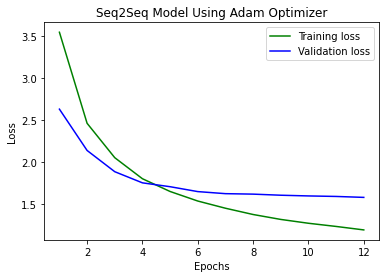

In [ ]:
plot_train_valid_loss(avg_train_losses, avg_valid_losses, 12, "Seq2Seq Model Using Adam Optimizer")